In [1]:
#makes sure to reload our modules on each execution

%load_ext autoreload 
%autoreload 1
%aimport gans, preprocessing, sourceSeparation

import concurrent.futures
import matplotlib.pyplot as plt
import torch
import pickle
import numpy as np

In [40]:
# constants

batchSize = 64
noiseDim = 200
includedSimulations=24



In [64]:
# generates preprocessed datasets for our models and saves them to disk
trainSpikesLoader, valSpikesLoader, testSpikesLoader, trainBgLoader, valBgLoader, testBgLoader = preprocessing.gen_loaders( 
    batchSize,
    includedSimulations,
    doDrown=True,
    drownRatio=0.3
)

pickle.dump(trainSpikesLoader, open("../data/trainSpikesLoader.drowned.03.pickle", "wb"))
pickle.dump(valSpikesLoader, open("../data/valSpikesLoader.drowned.03.pickle", "wb"))
pickle.dump(testSpikesLoader, open("../data/testSpikesLoader.drowned.03.pickle", "wb"))
pickle.dump(trainBgLoader, open("../data/trainBgLoader.drowned.03.pickle", "wb"))
pickle.dump(valBgLoader, open("../data/valBgLoader.drowned.03.pickle", "wb"))
pickle.dump(testBgLoader, open("../data/testBgLoader.drowned.03.pickle", "wb"))

Simularea 1
Simularea 2
Simularea 3
Simularea 4
Simularea 5
Simularea 6
Simularea 7
Simularea 8
Simularea 9
Simularea 10
Simularea 11
Simularea 12
Simularea 13
Simularea 14
Simularea 15
Simularea 16
Simularea 17
Simularea 18
Simularea 19
Simularea 20
Simularea 21
Simularea 22
Simularea 23
Simularea 24


In [81]:
#loads preprocessed datasets from disk
toLoad = ".03"

trainSpikesLoader = pickle.load(open(f"../data/trainSpikesLoader.drowned{toLoad}.pickle", "rb"))
valSpikesLoader = pickle.load(open(f"../data/valSpikesLoader.drowned{toLoad}.pickle", "rb"))
testSpikesLoader = pickle.load(open(f"../data/testSpikesLoader.drowned{toLoad}.pickle", "rb"))
trainBgLoader = pickle.load(open(f"../data/trainBgLoader.drowned{toLoad}.pickle", "rb"))
valBgLoader = pickle.load(open(f"../data/valBgLoader.drowned{toLoad}.pickle", "rb"))
testBgLoader = pickle.load(open(f"../data/testBgLoader.drowned{toLoad}.pickle", "rb"))

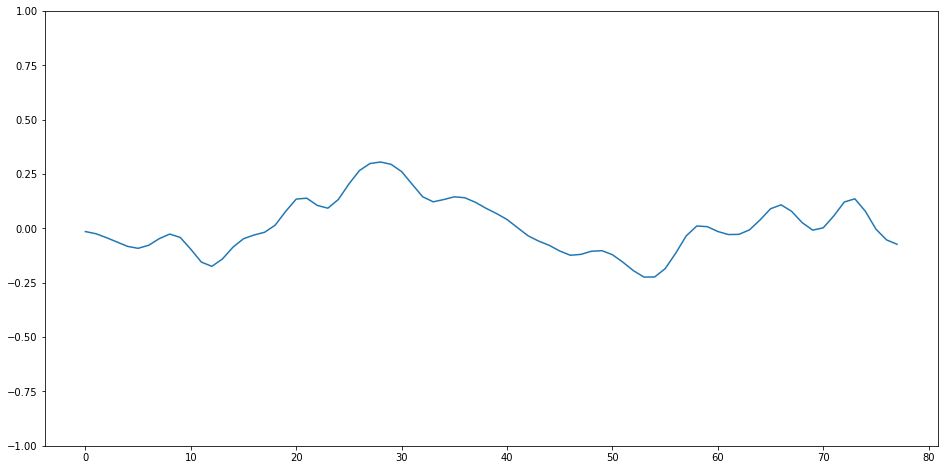

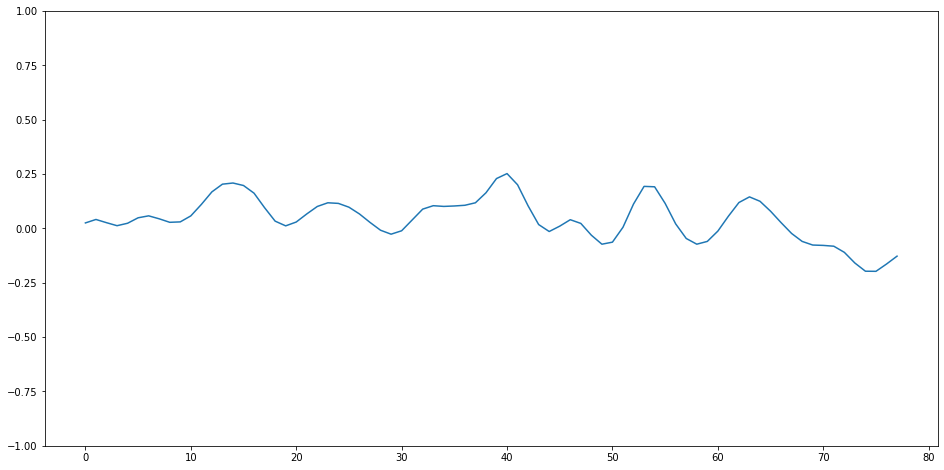

In [82]:
spikes = []
noise = []
for [x] in trainSpikesLoader:
    for y in x:
        spikes.append(y)
    break
        
for [x] in trainBgLoader:
    for y in x:
        noise.append(y)
    break

spikeIndex = 3
    
plt.ylim(-1,1)
plt.plot(torch.fft.irfft(spikes[spikeIndex][0:40] + 1j * spikes[spikeIndex][40:]).cpu().detach().numpy())
#plt.plot(spikes[1].cpu().detach().numpy())
plt.show()
plt.ylim(-1,1)
plt.plot(torch.fft.irfft(noise[1][0:40] + 1j * noise[1][40:]).cpu().detach().numpy())
#plt.plot(noise[1].cpu().detach().numpy())
plt.show()

Spike generator training


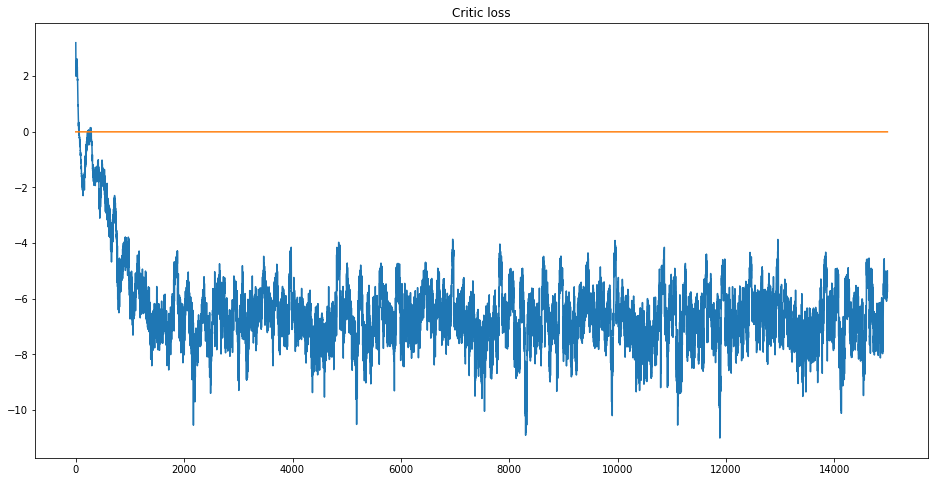

Critic loss -5.008906841278076

Epoch 4

Generated example:


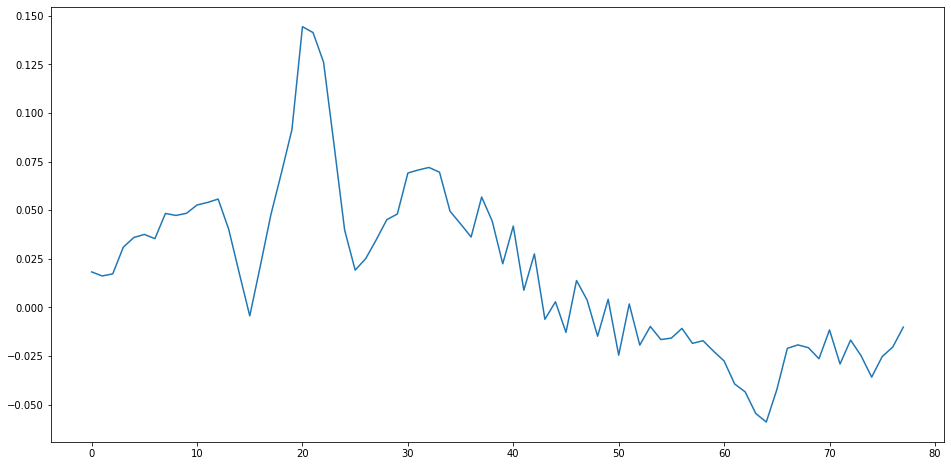

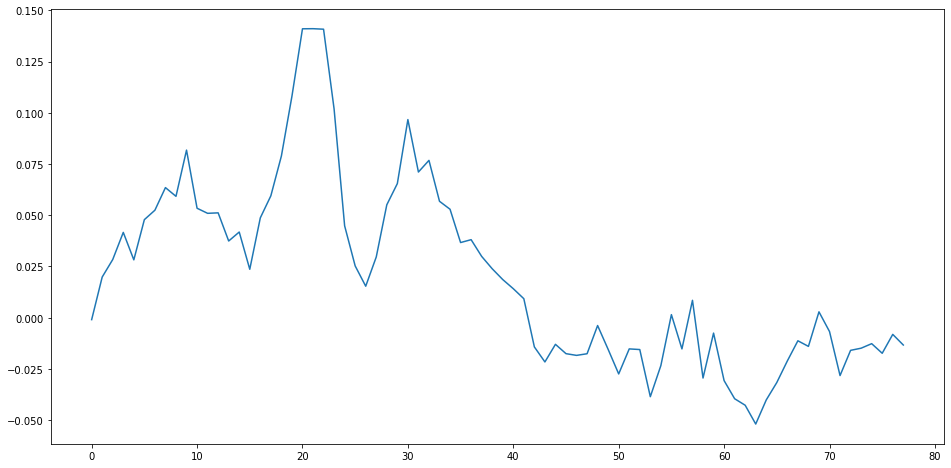

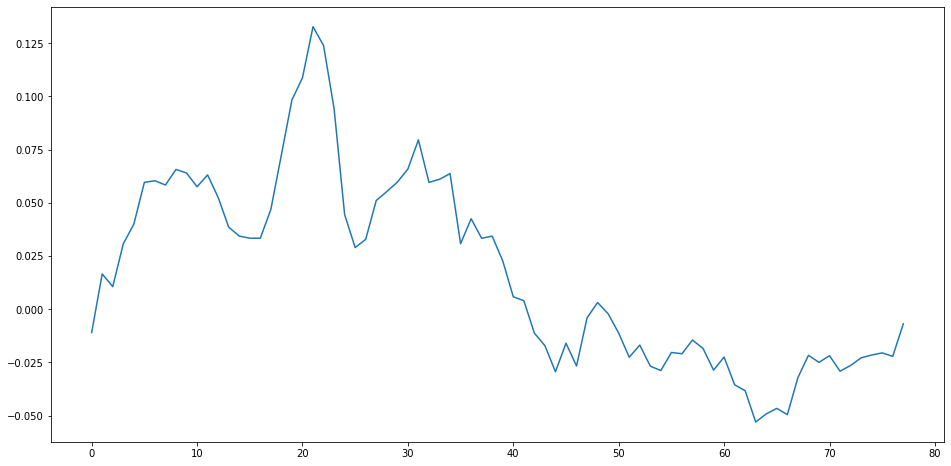

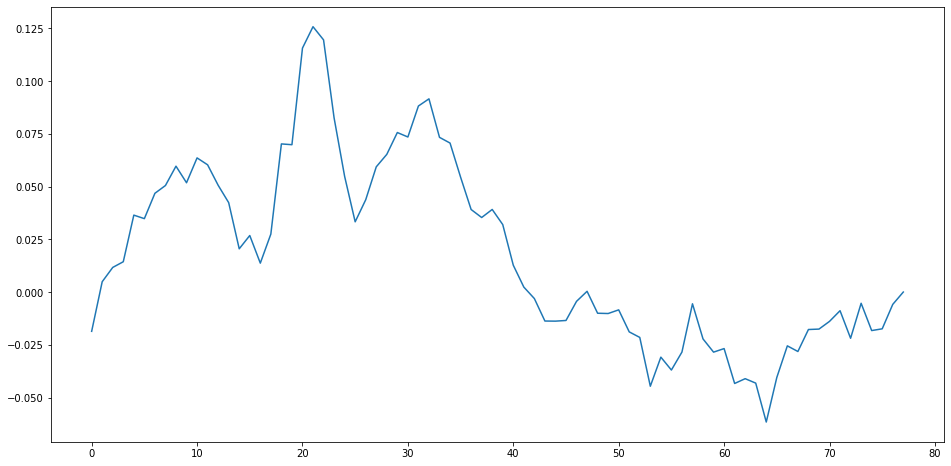

In [85]:
# declares and trains the gan for spikes 

gen1 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
critic1 = gans.CriticWgan(inputSize=80, hiddenSize=40)

print("Spike generator training")

gans.wgan_adversarial_trainer( 
    train_loader = trainSpikesLoader,
    generator = gen1, 
    critic = critic1, 
    batchSize = batchSize,
    noiseDim = noiseDim,
    epochs = 5,
)

In [83]:
# declares and trains the gan for hash

gen2 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=10, outputSize=80)
critic2 = gans.CriticWgan(inputSize=80, hiddenSize=40)
print("Background generator training")

gans.wgan_adversarial_trainer( 
    train_loader = trainBgLoader,
    generator = gen2, 
    critic = critic2, 
    batchSize = batchSize,
    noiseDim = noiseDim,
    epochs = 2,
)

Background generator training


KeyboardInterrupt: 

In [86]:
torch.save(gen1.state_dict(),"../data/models/gen1.03.pth")
torch.save(critic1.state_dict(),"../data/models/critic1.03.pth")
#torch.save(gen2.state_dict(),"../data/models/gen2.pth")
#torch.save(critic2.state_dict(),"../data/models/critic2.pth")

In [84]:

gen2 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=10, outputSize=80)
critic2 = gans.CriticWgan(inputSize=80, hiddenSize=40)
#load the generator 
gen2.load_state_dict(torch.load("../data/models/gen2.pth"))
gen2.to(gans.device)
#load the critic
critic2.load_state_dict(torch.load("../data/models/critic2.pth"))
critic2.to(gans.device)

_netC_wgan(
  (mainModule): Sequential(
    (0): Linear(in_features=80, out_features=40, bias=True)
    (1): Tanh()
    (2): Linear(in_features=40, out_features=1, bias=True)
  )
)

torch.Size([23961, 80])


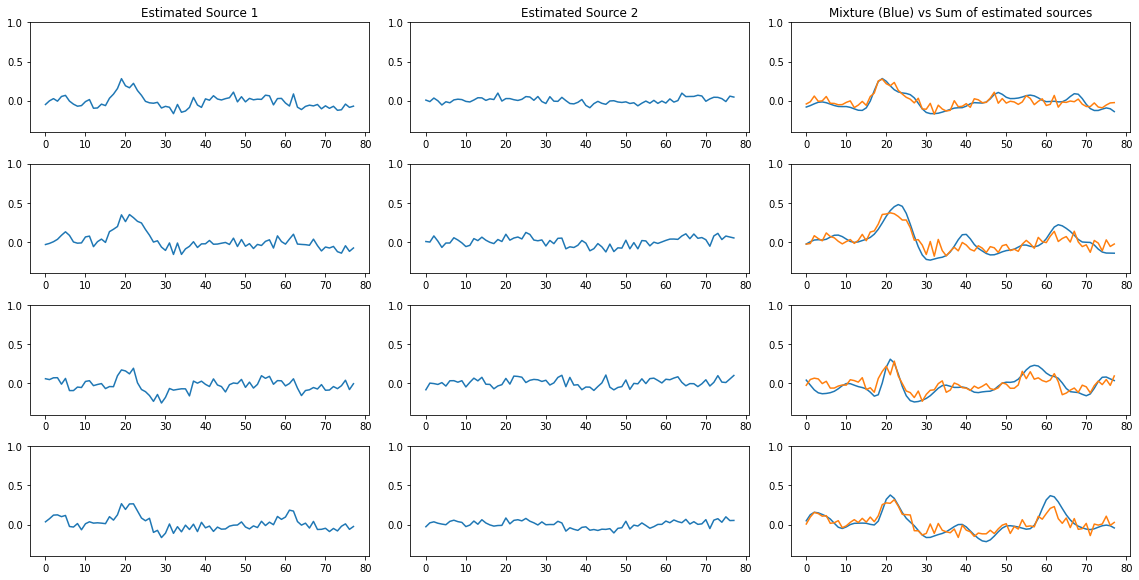

In [87]:
# separates the spike samples

(cleanextractedSpikesValidationSpikes,cleanextractedNoisesValidationSpikes) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=valSpikesLoader,
    epochs=3000
)

torch.Size([23961, 80])


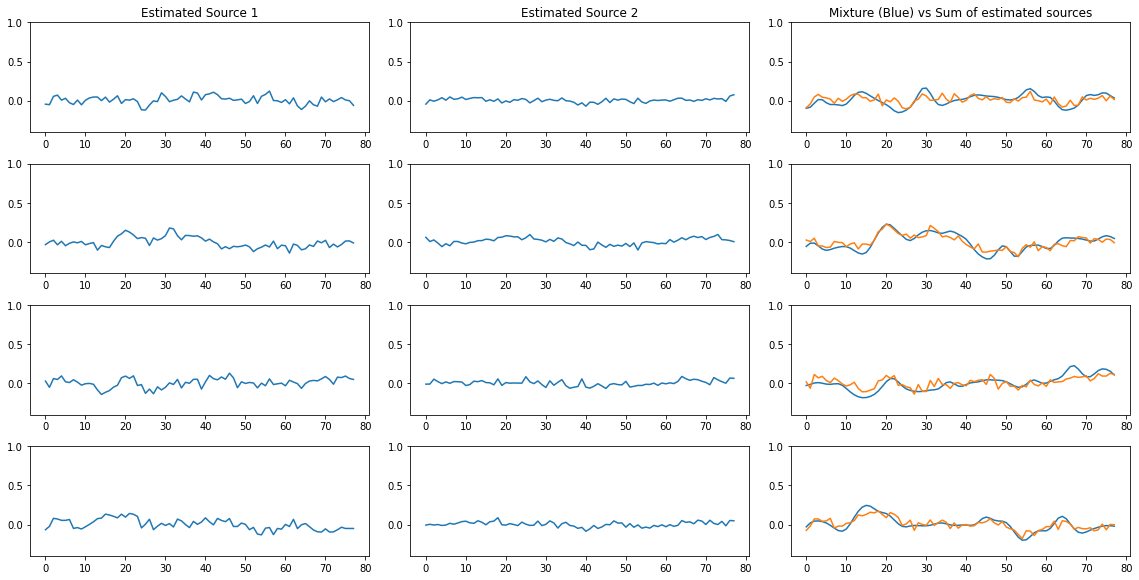

In [88]:
# separates the noise samples

(cleanextractedSpikesValidationBg,cleanextractedNoisesValidationBg) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=valBgLoader,
    epochs=3000
)

In [89]:
valExtractedSpikes = np.concatenate((cleanextractedSpikesValidationSpikes,cleanextractedSpikesValidationBg),axis=0)
vallabel = np.concatenate(([1 for _ in cleanextractedSpikesValidationSpikes],[0 for _ in cleanextractedSpikesValidationBg]),axis=0)

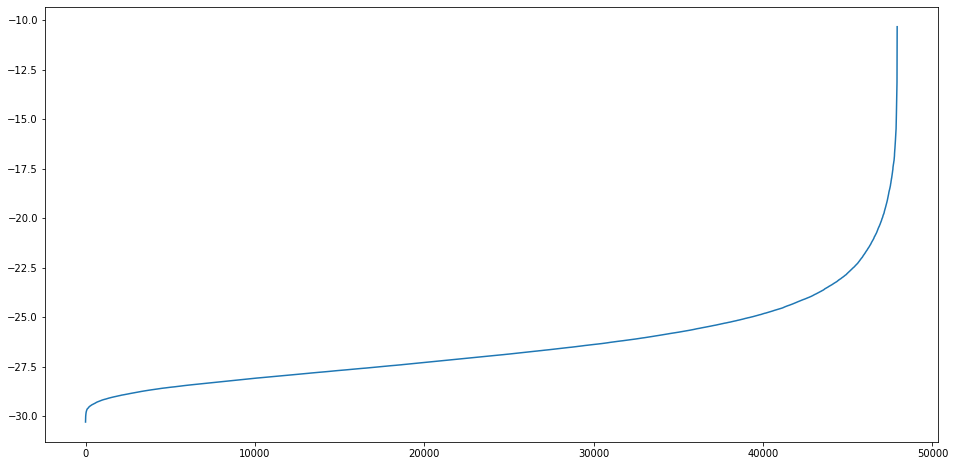

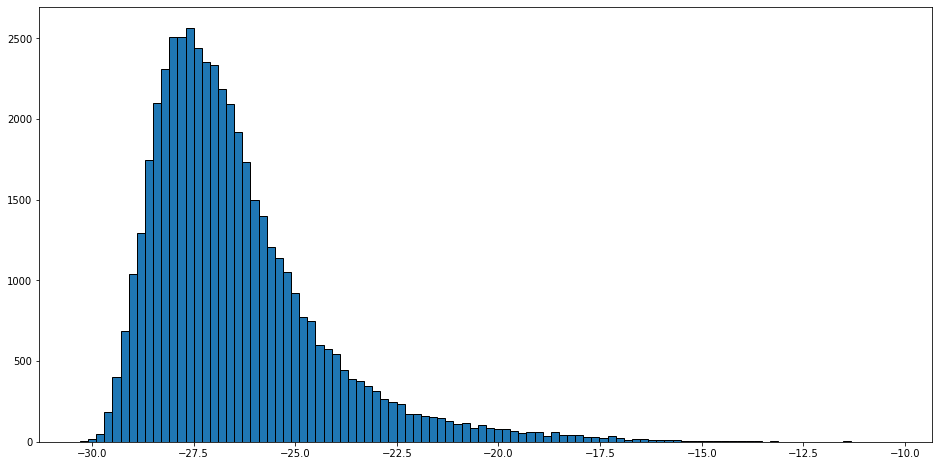

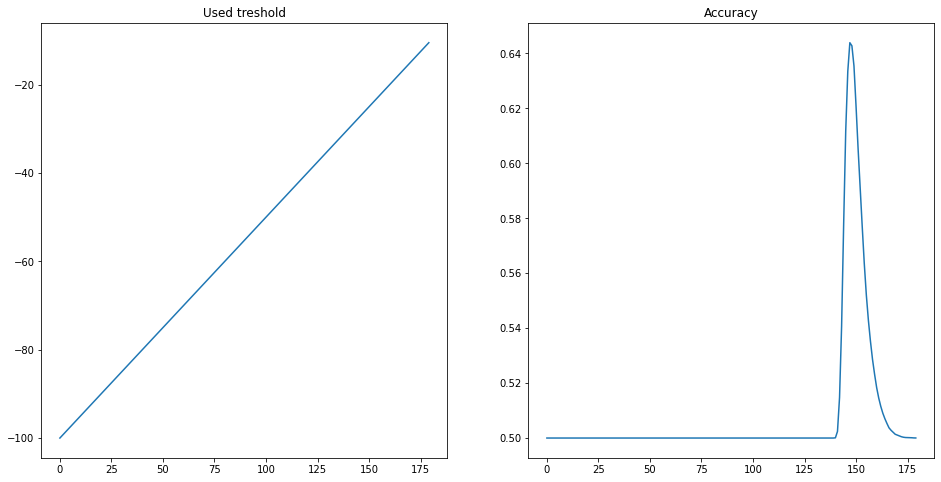

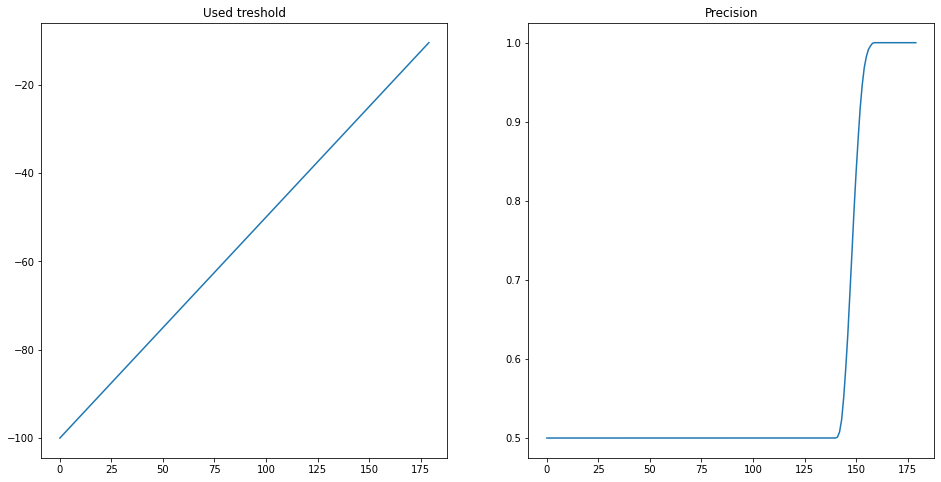

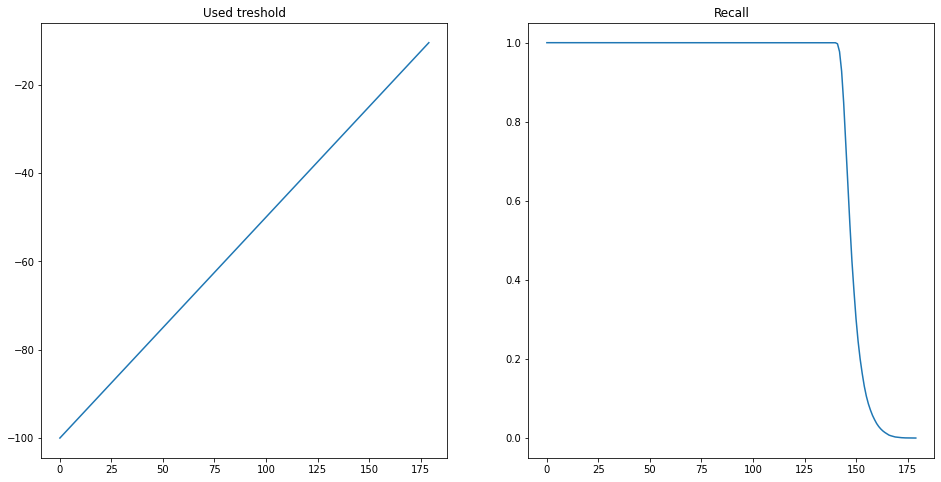

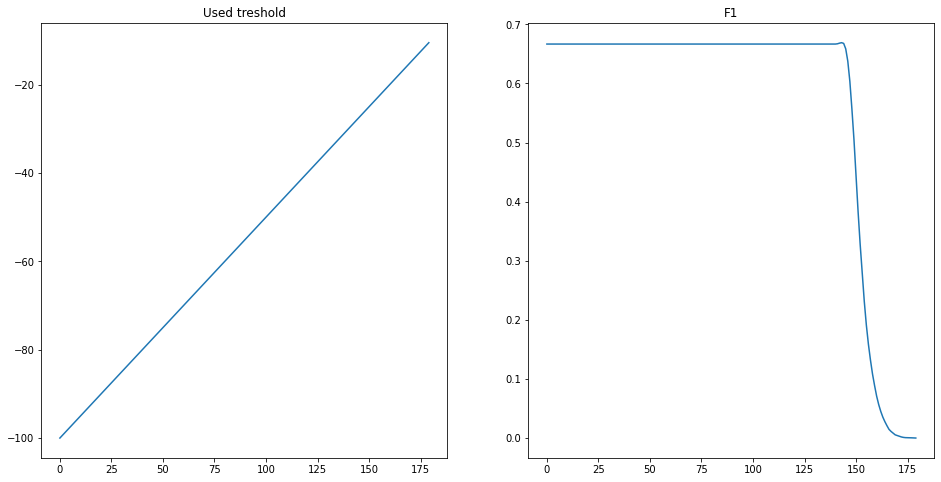

Threshold for best F1: -28.5
Threshold: -28.5
Precision: 0.5229506654752387
Recall: 0.9281332164767747
F1: 0.6689728819167657
Accuracy: 0.540732857560202


In [90]:
sourceSeparation.interpretSeparation(valExtractedSpikes, critic1, vallabel,method="critic")

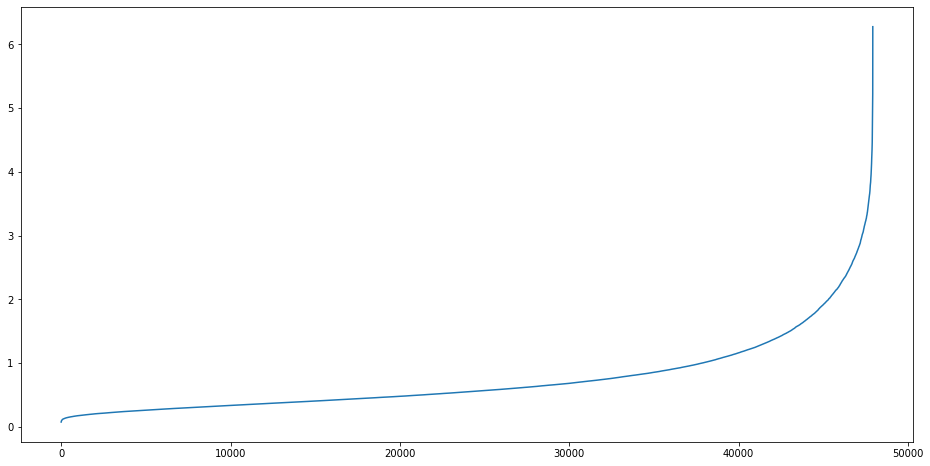

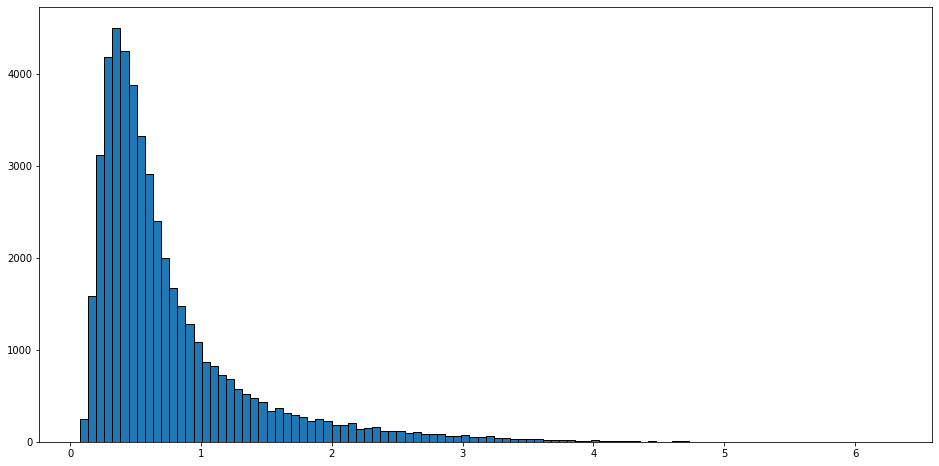

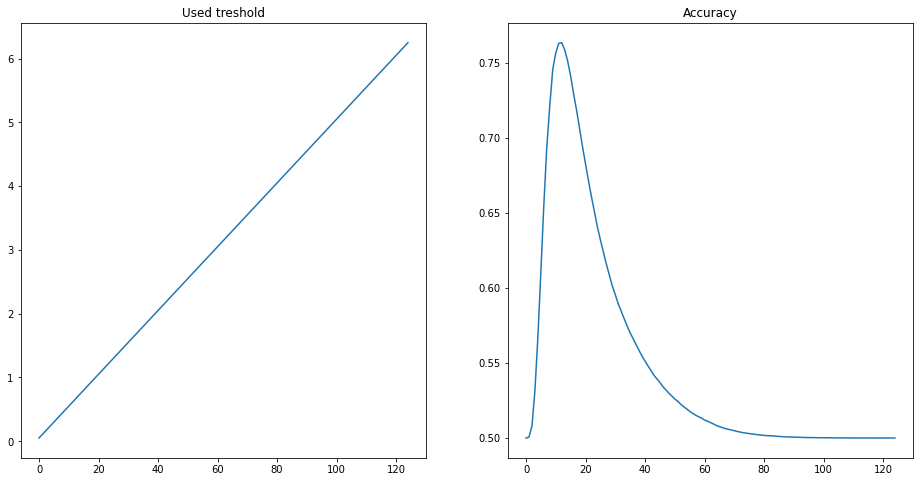

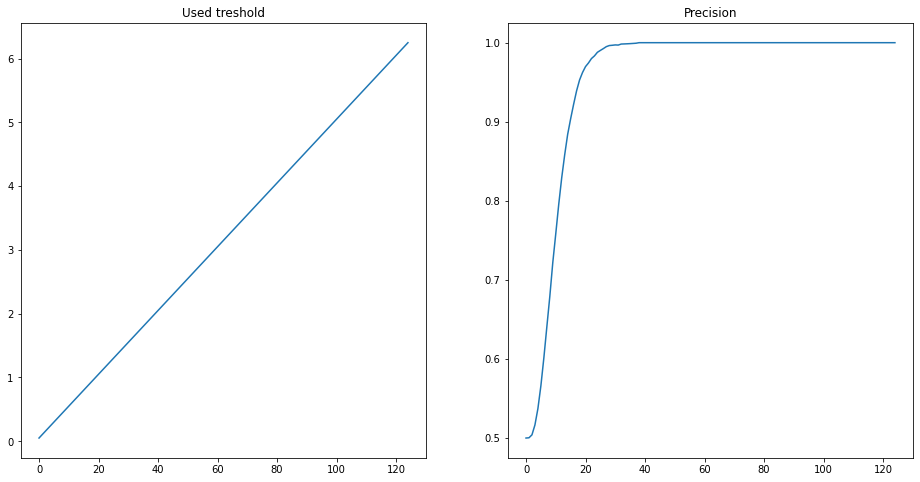

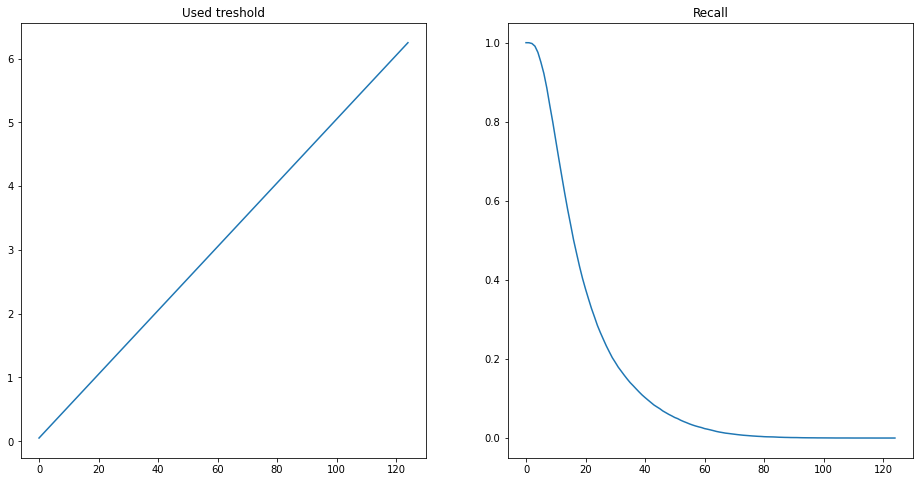

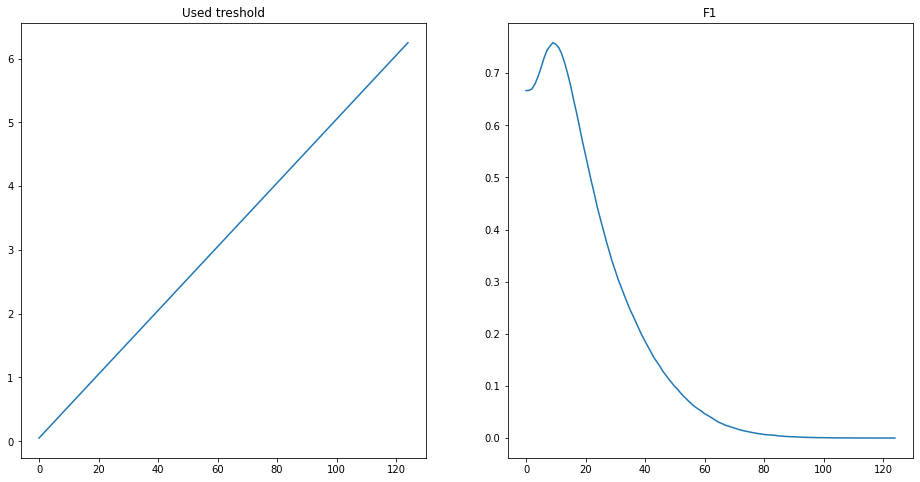

Threshold for best F1: 0.5
Threshold: 0.5
Precision: 0.7218473138548539
Recall: 0.7990901882225283
F1: 0.7585073089569386
Accuracy: 0.745586578189558


In [91]:
sourceSeparation.interpretSeparation(valExtractedSpikes, critic1, vallabel,method="energy")

torch.Size([23949, 80])


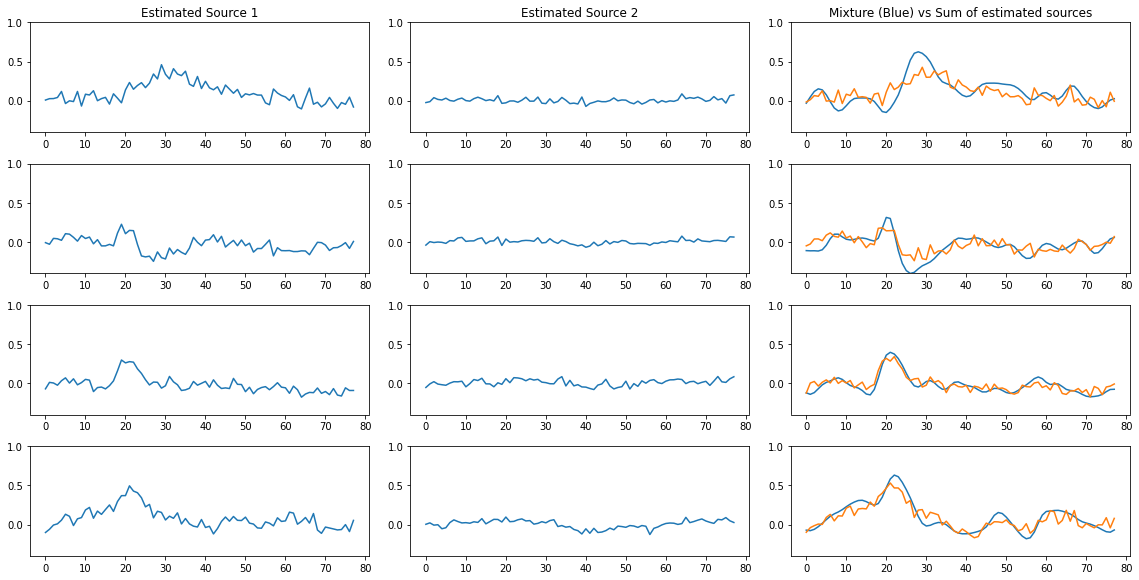

In [92]:
# separates the spike samples

(cleanextractedSpikesTestSpikes,cleanextractedNoisesTestSpikes) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=testSpikesLoader,
    epochs=2000
)

torch.Size([23949, 80])


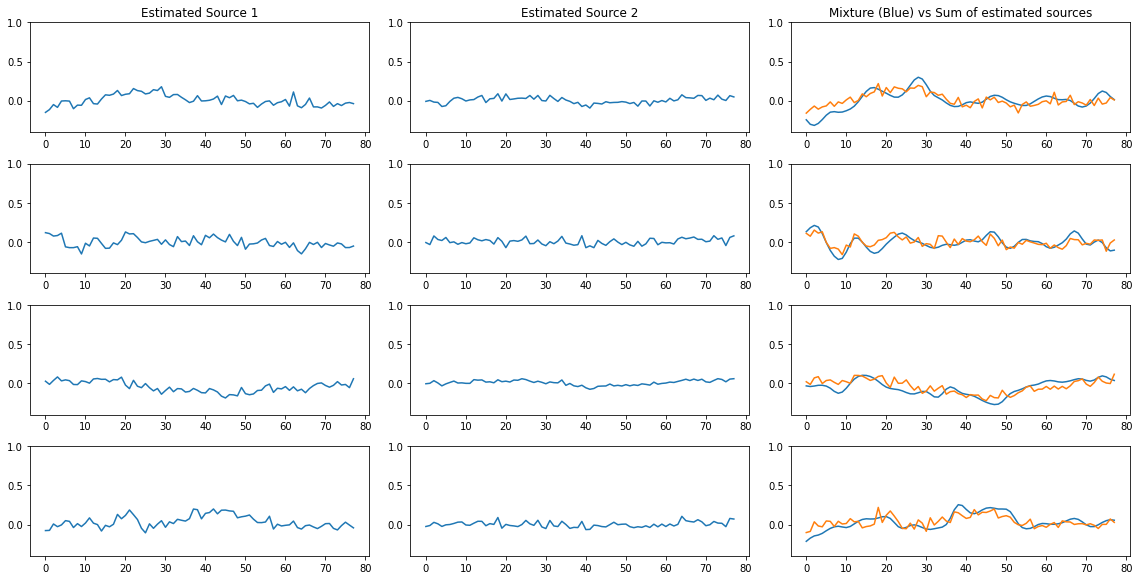

In [93]:
# separates the noise samples

(cleanextractedSpikesTestBg,cleanextractedNoisesTestBg) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=testBgLoader,
    epochs=2000
)

In [94]:
testExtractedSpikes = np.concatenate((cleanextractedSpikesTestSpikes,cleanextractedSpikesTestBg),axis=0)
testlabel = np.concatenate(([1 for _ in cleanextractedSpikesTestSpikes],[0 for _ in cleanextractedSpikesTestBg]),axis=0)

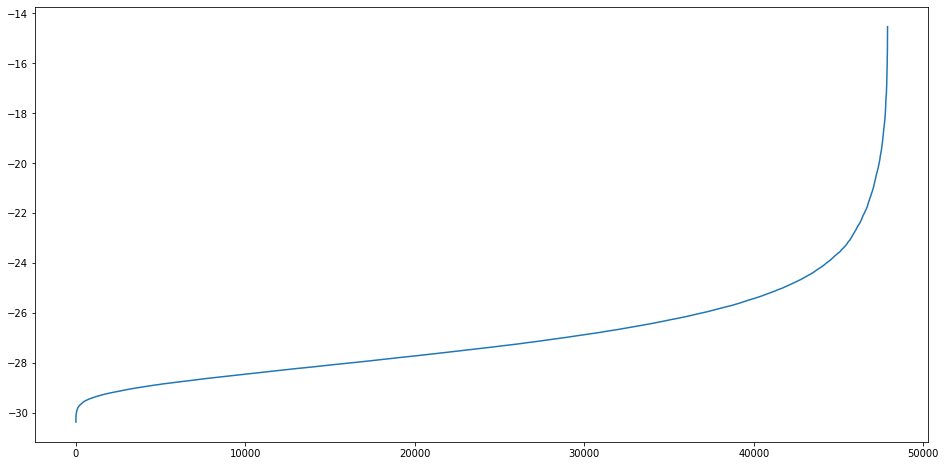

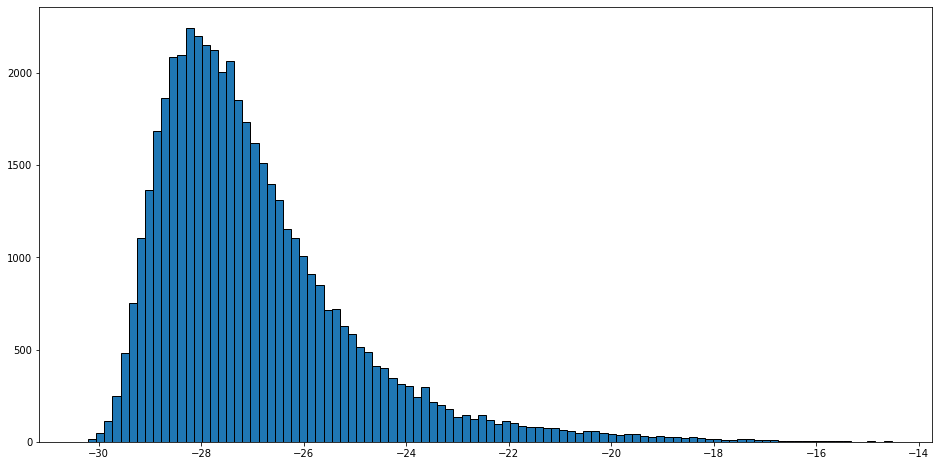

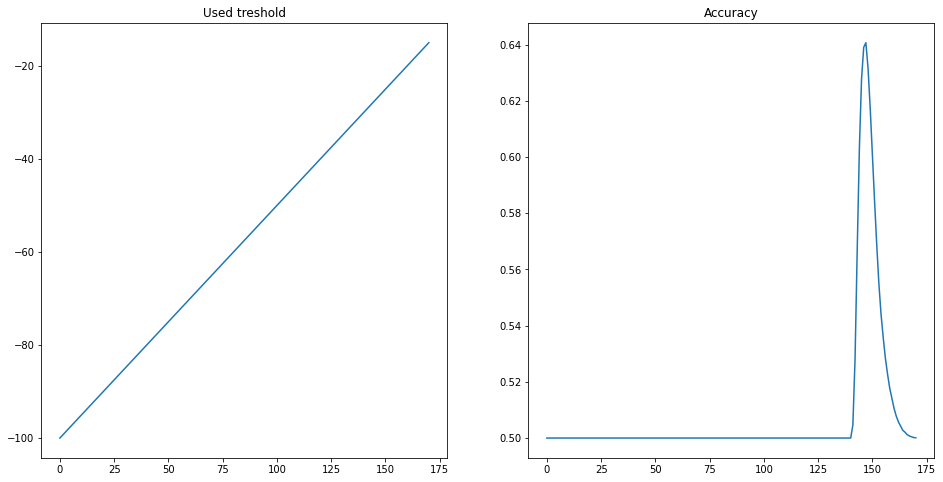

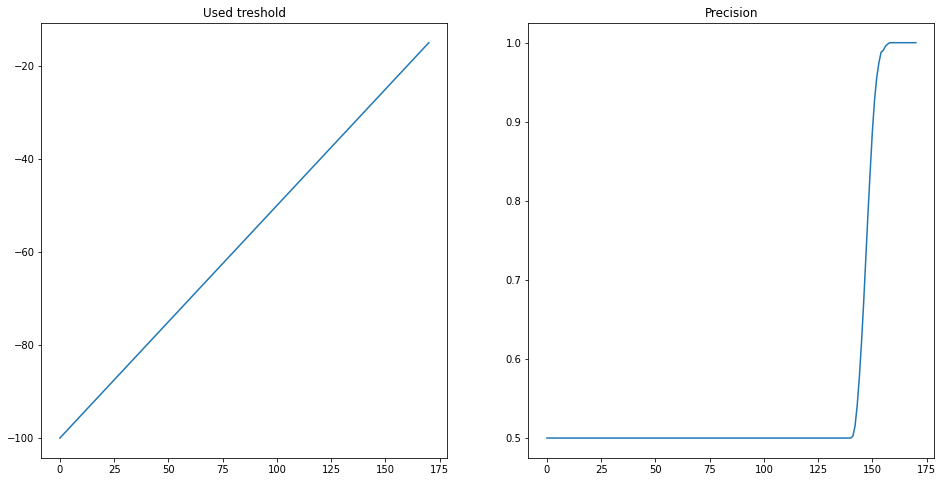

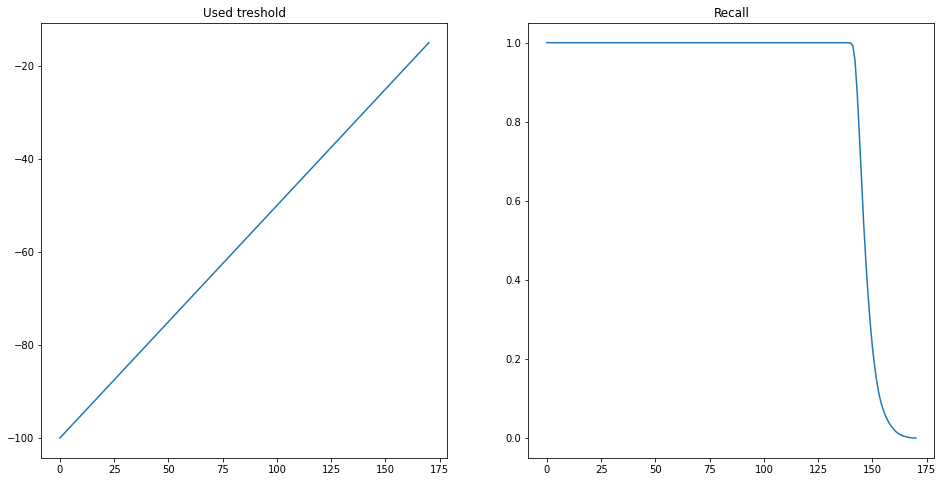

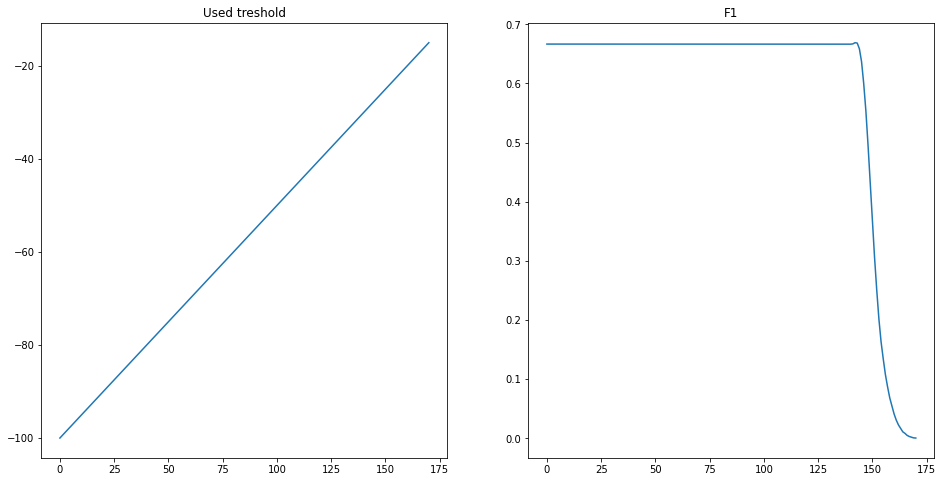

Threshold for best F1: -29.0
Threshold: -28.5
Precision: 0.5414692249928792
Recall: 0.8731471042632261
F1: 0.668424753867792
Accuracy: 0.5668712681114034


In [96]:
sourceSeparation.interpretSeparation(testExtractedSpikes, critic1, testlabel,test=True, testThreshold=-28.5,method="critic")

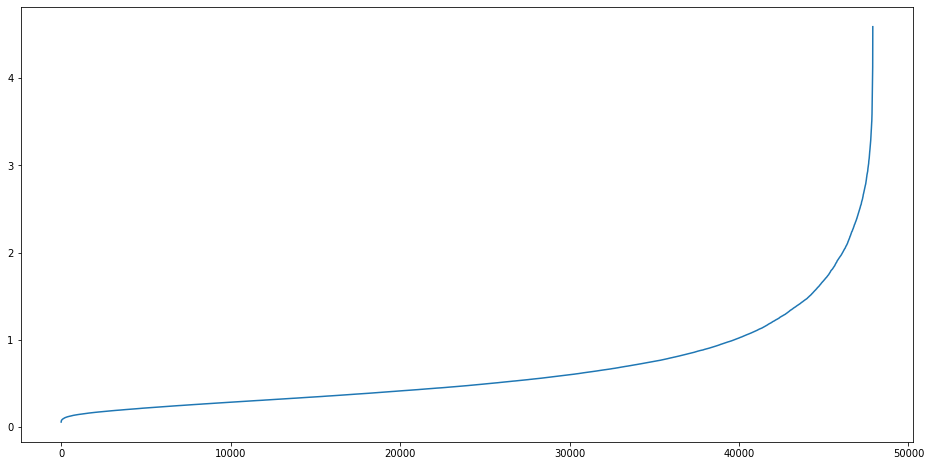

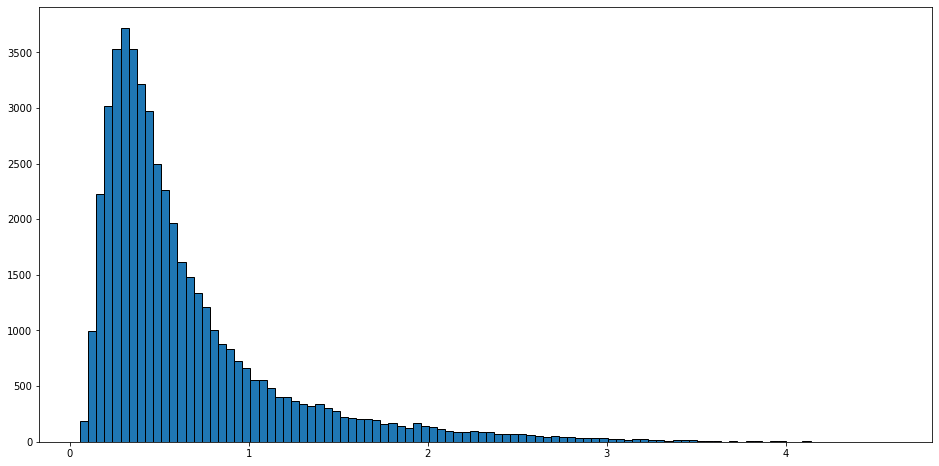

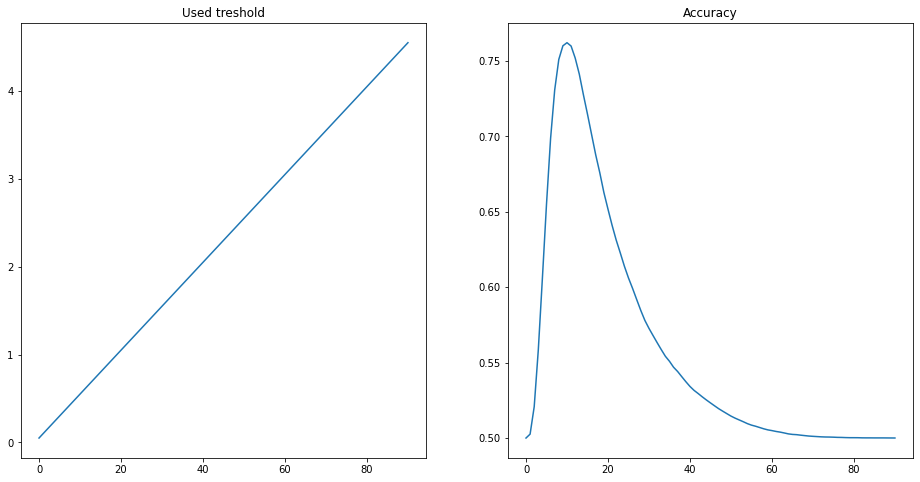

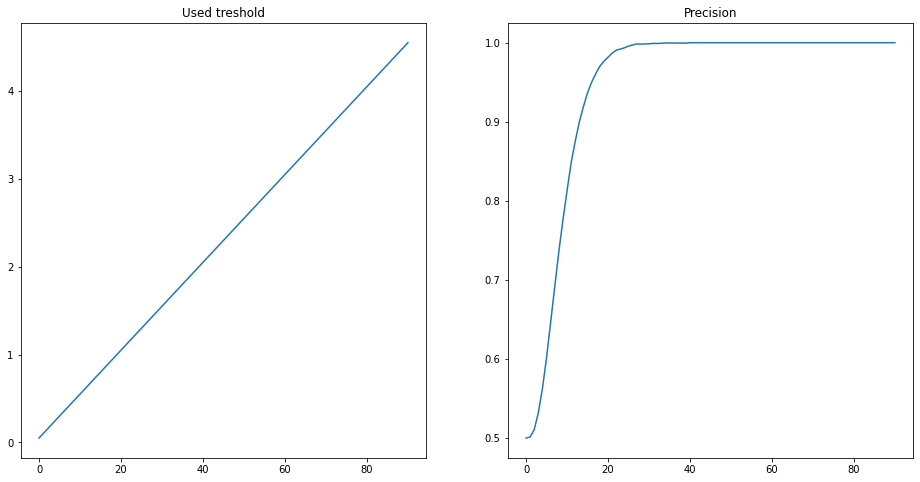

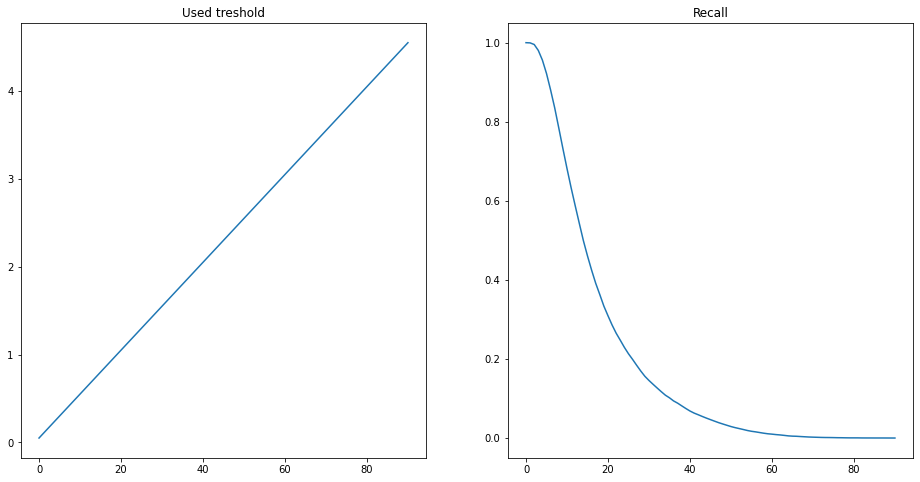

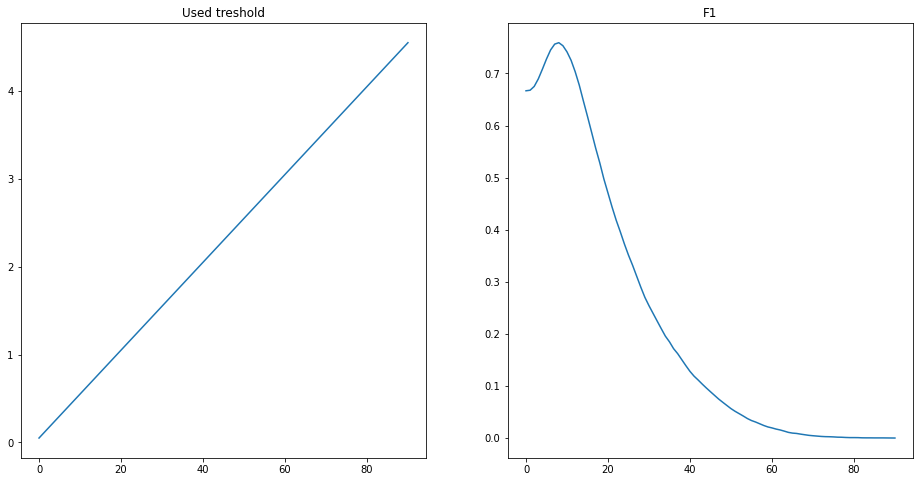

Threshold for best F1: 0.45
Threshold: 0.5
Precision: 0.7753216322560679
Recall: 0.7322643951730761
F1: 0.7531781480845215
Accuracy: 0.7600317341016326


In [95]:
sourceSeparation.interpretSeparation(testExtractedSpikes, critic1, testlabel,test=True, testThreshold=0.5,method="energy")